In [25]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

#from test_utils import summary, comparator

In [4]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './dataA/CameraRGB/')
mask_path = os.path.join(path, './dataA/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

Text(0.5, 1.0, 'Segmentation')

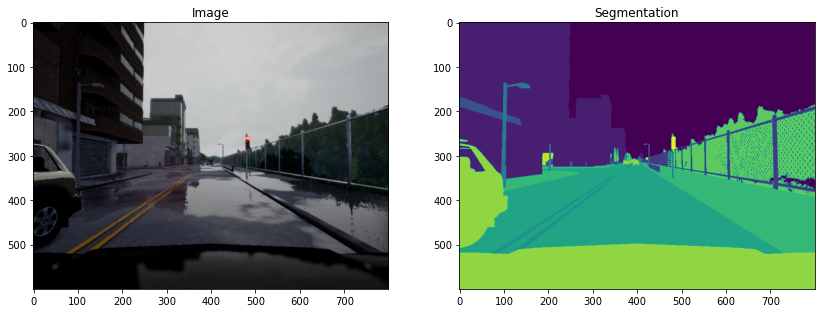

In [14]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])


fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:,:,0])
arr[1].set_title('Segmentation')

In [11]:
mask.shape

(600, 800, 3)

In [15]:
image_list_ds=tf.data.Dataset.list_files(image_list,shuffle=False)
mask_list_ds=tf.data.Dataset.list_files(mask_list,shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\dataA\\CameraRGB\\02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\dataA\\CameraMask\\02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\dataA\\CameraRGB\\02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\dataA\\CameraMask\\02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\dataA\\CameraRGB\\02_00_010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\dataA\\CameraMask\\02_00_010.png'>)


In [16]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'./dataA/CameraMask/02_00_000.png', shape=(), dtype=string)


In [24]:
dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [17]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [26]:
def conv_block(inputs=None,n_filters=32,dropout_prob=0,max_pooling=True):
    
    conv=Conv2D(n_filters,3,activation='relu',padding='same',kernel_initializer='he_normal')(inputs)
    conv=Conv2D(n_filters,3,activation='relu',padding='same',kernel_initializer='he_normal')(conv)
    
    if dropout_prob>0:
        conv=Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer=MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv)
        
    else:
        next_layer=conv
        
    skip_connection=conv
    return next_layer,skip_connection


In [27]:
def unsampling_block(expansive_input,contractive_input,n_filters=32):
    
    up=Conv2DTranspose(n_filters,3,strides=(2,2),padding='same')(expansive_input)
    
    merge=concatenate([up,contractive_input],axis=3)
    conv=Conv2D(n_filters,3,activation='relu',
               padding='same',
               kernel_initializer='he_normal')(merge)
    conv=Conv2D(n_filters,3,activation='relu',
               padding='same',
               kernel_initializer='he_normal')(conv)
    
    return conv

In [38]:
def unet_model(input_size=(96,128,3),n_filters=32,n_classes=23):
    inputs=Input(input_size)
    
    cblock1=conv_block(inputs,n_filters)
    cblock2=conv_block(cblock1[0],n_filters*2)
    cblock3=conv_block(cblock2[0],n_filters*4)
    cblock4=conv_block(cblock3[0],n_filters*8,dropout_prob=0.3)
    cblock5=conv_block(cblock4[0],n_filters*16,dropout_prob=0.3,max_pooling=False)
    
    ublock6=unsampling_block(cblock5[0],cblock4[1],n_filters*8)
    ublock7=unsampling_block(ublock6,cblock3[1],n_filters*4)
    ublock8=unsampling_block(ublock7,cblock2[1],n_filters*2)
    ublock9=unsampling_block(ublock8,cblock1[1],n_filters)
    
    conv9=Conv2D(n_filters,3,activation='relu',
                padding='same',kernel_initializer='he_normal')(ublock9)
    
    conv10=Conv2D(n_classes,1,padding='same')(conv9)
    
    model=tf.keras.Model(inputs=inputs,outputs=conv10)
    
    return model

In [39]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [41]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 96, 128, 32)  896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 96, 128, 32)  9248        conv2d_56[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 48, 64, 32)   0           conv2d_57[0][0]                  
______________________________________________________________________________________________

In [42]:
unet.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

In [43]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

(600, 800, 1)


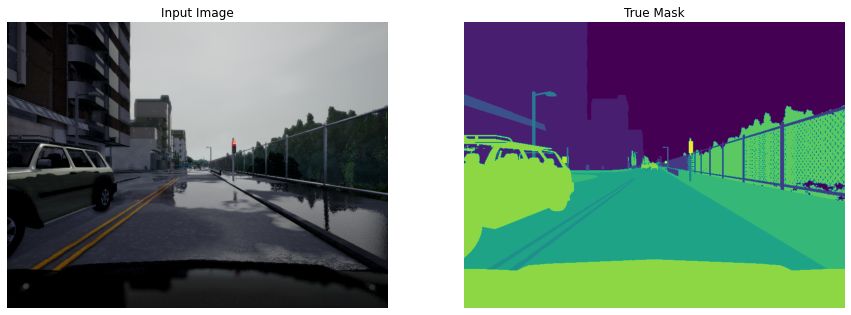

In [44]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


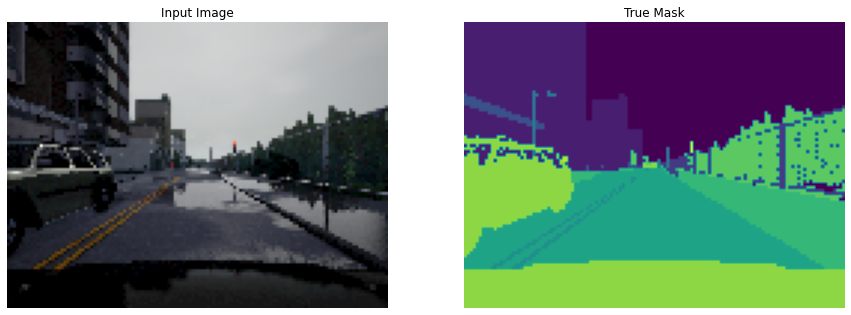

In [45]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [46]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
32/32 [==============================] - 134s 4s/step - loss: 2.0488 - accuracy: 0.3774
Epoch 2/40
32/32 [==============================] - 129s 4s/step - loss: 0.9312 - accuracy: 0.7144
Epoch 3/40
32/32 [==============================] - 126s 4s/step - loss: 0.6362 - accuracy: 0.7898
Epoch 4/40
32/32 [==============================] - 134s 4s/step - loss: 0.5370 - accuracy: 0.8133
Epoch 5/40
32/32 [==============================] - 126s 4s/step - loss: 0.4714 - accuracy: 0.8452
Epoch 6/40
32/32 [==============================] - 125s 4s/step - loss: 0.4303 - accuracy: 0.8634
Epoch 7/40
32/32 [==============================] - 141s 4s/step - loss: 0.3826 - accuracy: 0.8812
Epoch 8/40
32/32 [==============================] - 152s 5s/step - loss: 0.3360 - accuracy: 0.8957
Epoch 9/40
32/32 [==============================] - 135s 4s/step - loss: 0.3181 - accur

In [47]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

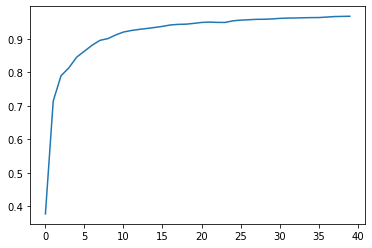

In [48]:
plt.plot(model_history.history["accuracy"])

In [49]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

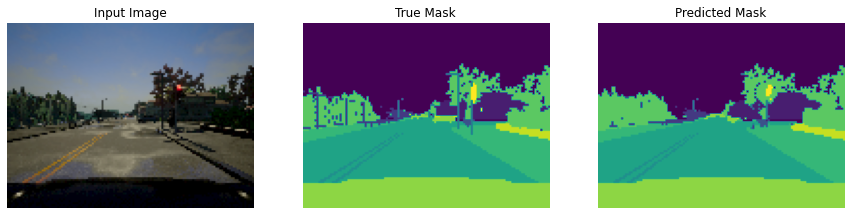

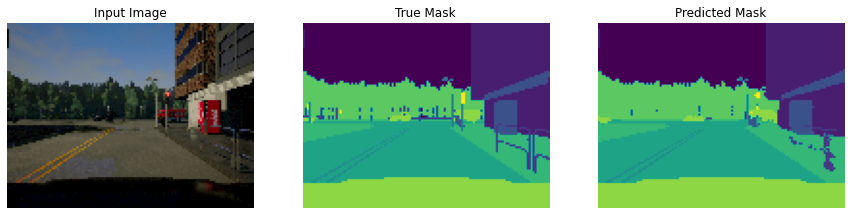

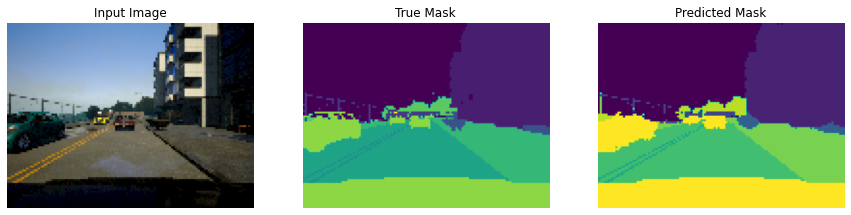

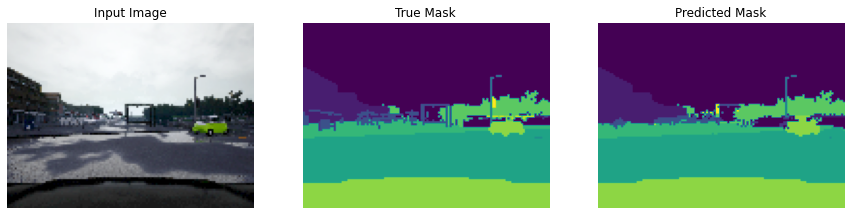

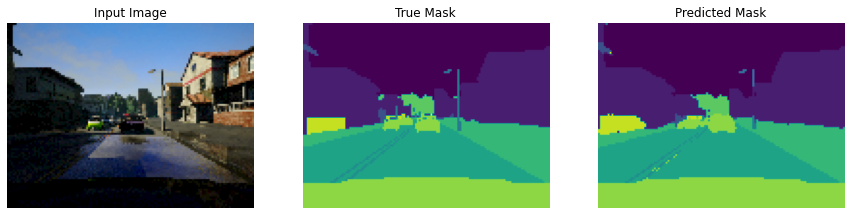

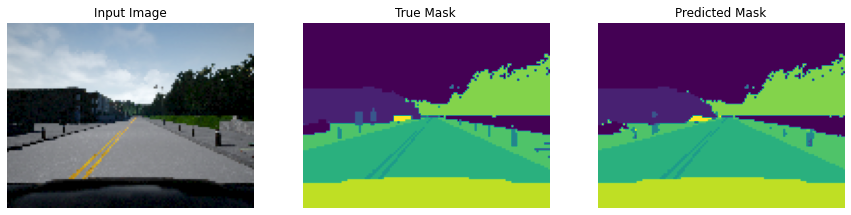

In [50]:
show_predictions(train_dataset, 6)